# Assignment project on Machine learning (pose classification)

## Create new dataset 

author: Nguyen Xuan Tung

---------------------------------------------------------------------------------------------------

In [1]:
import os
import torch

from models.model import ViTPose
from configs.ViTPose_base_coco_256x192 import model as model_cfg

import onnx
import onnxruntime

import cv2
import numpy as np
import matplotlib.pyplot as plt


from time import time
from PIL import Image
from torchvision.transforms import transforms

from utils.visualization import draw_points_and_skeleton, joints_dict
from utils.dist_util import get_dist_info, init_dist
from utils.top_down_eval import keypoints_from_heatmaps

# Torch to ONNX

In [2]:
path = "vitpose-b-multi-coco.pth"
C, H, W = (3, 256, 192)

model = ViTPose(model_cfg)
ckpt = torch.load(path)
model.load_state_dict(ckpt['state_dict'])
model.eval()

output_onnx = 'vitpose_dynamic.onnx'
input_names = ["input_0"]
output_names = ["output_0"]

device = next(model.parameters()).device
inputs = torch.randn(1, C, H, W).to(device)

dynamic_axes = {'input_0' : {0 : 'batch_size'},
                'output_0' : {0 : 'batch_size'}}

torch_out = torch.onnx.export(model, inputs, output_onnx, export_params=True, verbose=False,
                              input_names=input_names, output_names=output_names, 
                              opset_version=11, dynamic_axes = dynamic_axes)
print(f">>> Saved at: {os.path.abspath(output_onnx)}")

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

>>> Saved at: D:\Physics-Data-Msc\Assignment_internship\ViTPose_pytorch\vitpose_dynamic.onnx


# Inference with ONNX

>>> Original image size: 4239 X 2826 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 16.55859375, 14.71875
>>> Output size: (1, 17, 64, 48) ---> 0.3972 sec. elapsed [ 2.5 fps]



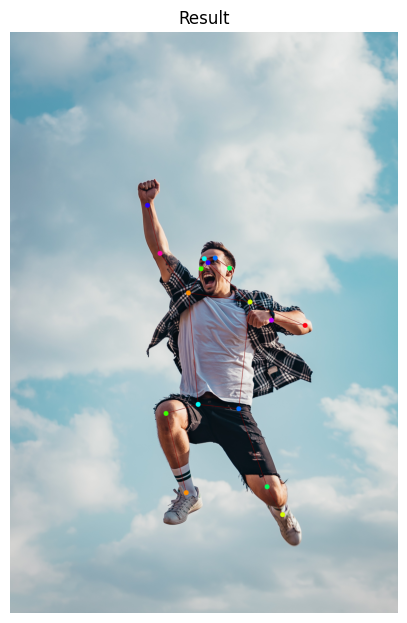

>>> Original image size: 612 X 481 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.390625, 2.5052083333333335
>>> Output size: (1, 17, 64, 48) ---> 0.3910 sec. elapsed [ 2.6 fps]



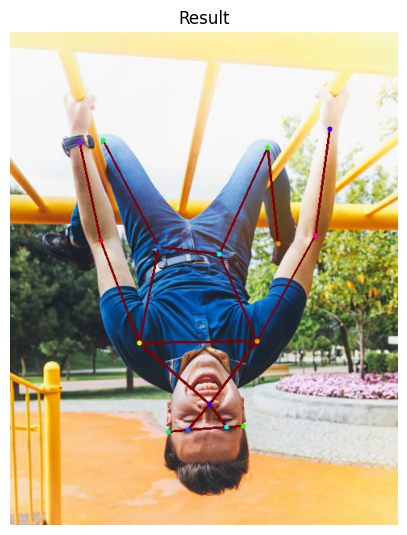

>>> Original image size: 183 X 275 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 0.71484375, 1.4322916666666667
>>> Output size: (1, 17, 64, 48) ---> 0.3939 sec. elapsed [ 2.5 fps]



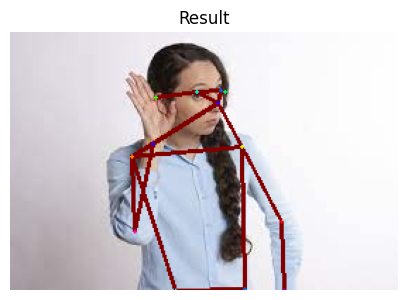

>>> Original image size: 1001 X 1500 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.91015625, 7.8125
>>> Output size: (1, 17, 64, 48) ---> 0.3969 sec. elapsed [ 2.5 fps]



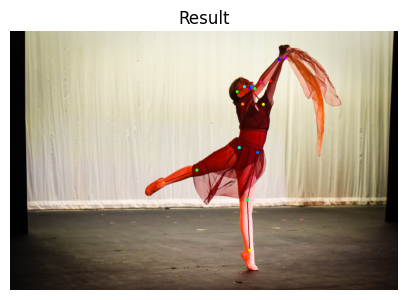

>>> Original image size: 612 X 408 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.390625, 2.125
>>> Output size: (1, 17, 64, 48) ---> 0.3780 sec. elapsed [ 2.6 fps]



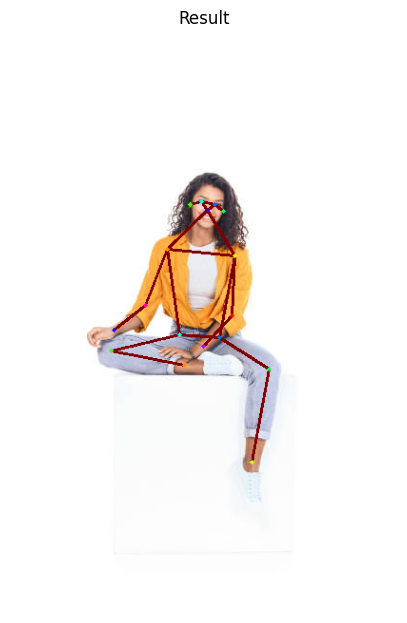

>>> Original image size: 339 X 509 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.32421875, 2.6510416666666665
>>> Output size: (1, 17, 64, 48) ---> 0.3700 sec. elapsed [ 2.7 fps]



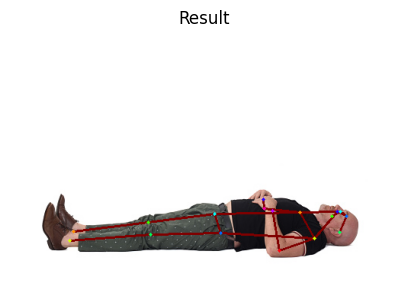

>>> Original image size: 408 X 612 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.59375, 3.1875
>>> Output size: (1, 17, 64, 48) ---> 0.3710 sec. elapsed [ 2.7 fps]



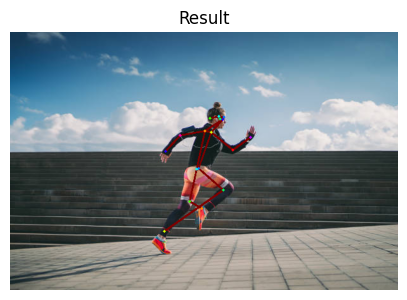

>>> Original image size: 339 X 509 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.32421875, 2.6510416666666665
>>> Output size: (1, 17, 64, 48) ---> 0.3583 sec. elapsed [ 2.8 fps]



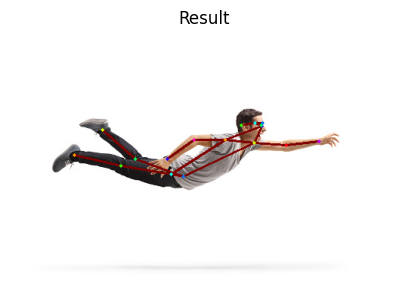

>>> Original image size: 406 X 1023 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 1.5859375, 5.328125
>>> Output size: (1, 17, 64, 48) ---> 0.3580 sec. elapsed [ 2.8 fps]



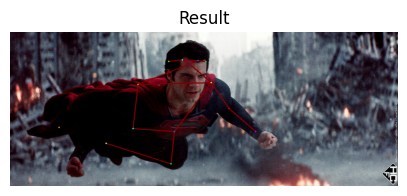

>>> Original image size: 612 X 421 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 2.390625, 2.1927083333333335
>>> Output size: (1, 17, 64, 48) ---> 0.4009 sec. elapsed [ 2.5 fps]



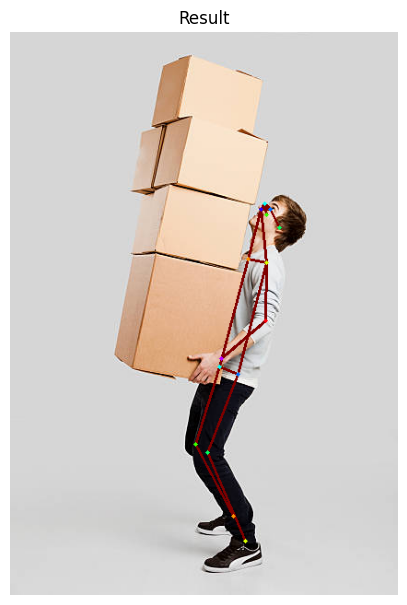

>>> Original image size: 4821 X 3214 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 18.83203125, 16.739583333333332
>>> Output size: (1, 17, 64, 48) ---> 0.3570 sec. elapsed [ 2.8 fps]



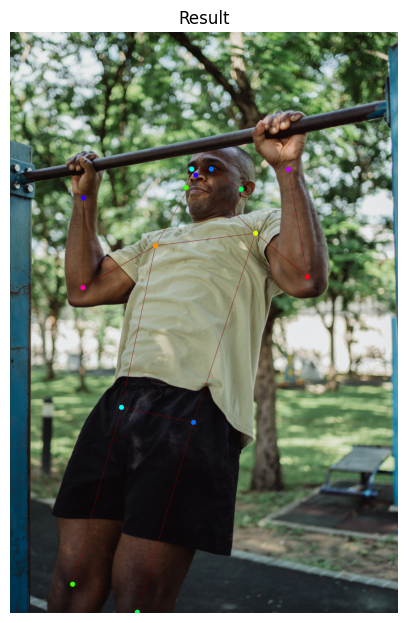

In [3]:
# Path to the folder containing images
IMAGE_FOLDER = "picture"

# List all image files in the folder
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.jpg'))]



def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = onnxruntime.InferenceSession(output_onnx)

# Iterate over the image files
for img_filename in image_files:
    IMG_PATH = os.path.join(IMAGE_FOLDER, img_filename)
    

    # Prepare input data
    img = Image.open(IMG_PATH)

    org_w, org_h = img.size
    print(f">>> Original image size: {org_h} X {org_w} (height X width)")
    print(f">>> Resized image size: {H} X {W} (height X width)")
    print(f">>> Scale change: {org_h/H}, {org_w/W}")
    img_tensor = transforms.Compose (
        [transforms.Resize((H, W)),
            transforms.ToTensor()]
    )(img).unsqueeze(0).to(device)


    # Feed to model
    tic = time()
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_tensor)}
    heatmaps = ort_session.run(None, ort_inputs)[0]
    # heatmaps = vit_pose(img_tensor).detach().cpu().numpy() # N, 17, h/4, w/4
    elapsed_time = time()-tic
    print(f">>> Output size: {heatmaps.shape} ---> {elapsed_time:.4f} sec. elapsed [{elapsed_time**-1: .1f} fps]\n")    

    # points = heatmap2coords(heatmaps=heatmaps, original_resolution=(org_h, org_w))
    points, prob = keypoints_from_heatmaps(heatmaps=heatmaps, center=np.array([[org_w//2, org_h//2]]), scale=np.array([[org_w, org_h]]),
                                            unbiased=True, use_udp=True)
    points = np.concatenate([points[:, :, ::-1], prob], axis=2)

    img = np.array(img)
    

    # Visualization 
    for pid, point in enumerate(points):
        img_vis = draw_points_and_skeleton(img.copy(), point, joints_dict()['coco']['skeleton'], person_index=pid,
                                            points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                            points_palette_samples=10, confidence_threshold=0.4)
        output_filename = f"heatmaps_{img_filename.replace('.', '_')}.npy"
        output_path = os.path.join(IMAGE_FOLDER, output_filename)
        np.save(output_path, heatmaps)


        plt.figure(figsize=(5,10))
        plt.imshow(img_vis)
        plt.title("Result")
        plt.axis('off')
        plt.show()
